# Explore TM-Align Results

In [514]:
import pandas as pd
results = pd.read_parquet('tmalign_rmsd_full.parquet').sort_values(by=['tm_score_norm_ref_p1'], ascending=False)
tm_score_threshold = 0.5
rmsd_threshold = 3
# Scores below 0.17 correspond to randomly chosen unrelated proteins whereas structures with a score higher than 0.5 assume generally the same fold in SCOP/CATH. (Zhang)
# Quantitative study shows that proteins of TM-score = 0.5 have a posterior probability of 37% in the same CATH topology family and of 13% in the same SCOP fold family. 
# The probabilities increase rapidly when TM-score > 0.5. (Wikipedia)
print('Num. Results:', len(results))

Num. Results: 67700


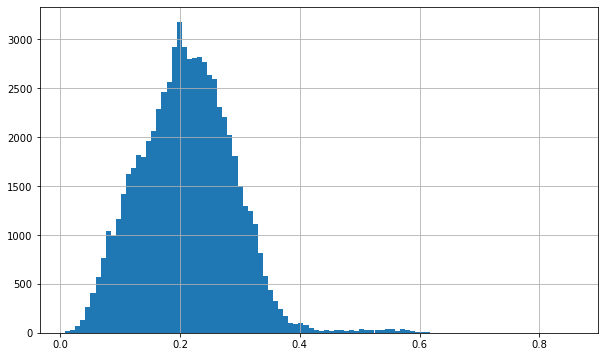

In [515]:
results.tm_score_norm_ref_p1.astype(float).hist(bins=100, figsize=(10,6));

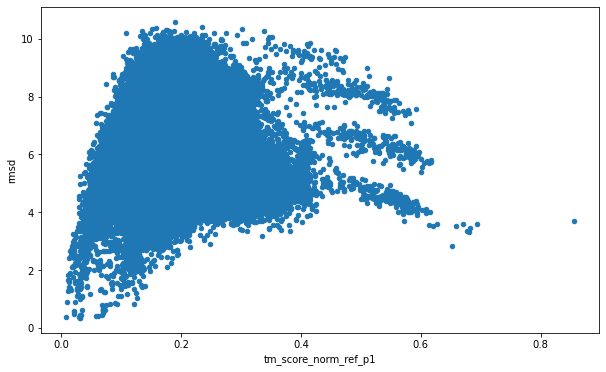

In [516]:
results[['rmsd', 'tm_score_norm_ref_p1']].astype(float).plot(x='tm_score_norm_ref_p1', y='rmsd', kind='scatter', figsize=(10,6));

In [517]:
results[results.tm_score_norm_ref_p1.astype(float) > tm_score_threshold]

,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tm_score_norm_ref_p1
0,AF-Q9NW08-F1-model_v1,1133,AF-Q9H9Y6-F1-model_v1,1135,1054,3.69,0.85502
0,AF-Q8N1S5-F1-model_v1,342,AF-Q13433-F1-model_v1,755,278,3.59,0.69422
0,AF-Q8N1S5-F1-model_v1,342,AF-Q6P5W5-F1-model_v1,647,279,3.47,0.68158
0,AF-Q8N1S5-F1-model_v1,342,AF-Q504Y0-F1-model_v1,691,269,3.31,0.6798
0,AF-Q8N1S5-F1-model_v1,342,AF-Q9BRY0-F1-model_v1,314,273,3.36,0.67734
...,...,...,...,...,...,...,...
0,AF-Q8N1S5-F1-model_v1,342,AF-Q12802-F1-model_v1,12413,273,6.35,0.50196
0,AF-Q8N1S5-F1-model_v1,342,AF-P78509-F1-model_v1,12642,274,6.12,0.50181
0,AF-Q8N1S5-F1-model_v1,342,AF-P46939-F1-model_v1,12392,275,6.32,0.50092
0,AF-P48449-F1-model_v1,732,AF-Q07954-F1-model_v1,12910,592,8.32,0.50053


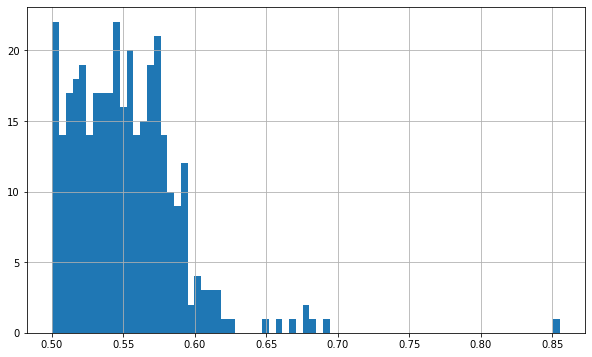

In [518]:
results[results.tm_score_norm_ref_p1.astype(float) > tm_score_threshold].tm_score_norm_ref_p1.astype(float).hist(bins=75, figsize=(10,6));

In [512]:
# We used three different RMSD classifications for docking solutions: (a) good solution when RMSD ≤ 2.0 Å [8,22], (b) acceptable solutions when RMSD is between 2.0 and 3.0 Å, and (c) bad solutions when RMSD ≥ 3.0 Å. 
# https://www.mdpi.com/1420-3049/23/5/1038/htm
results[(results.tm_score_norm_ref_p1.astype(float) > tm_score_threshold) & (results.rmsd.astype(float) < rmsd_threshold)]

,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tm_score_norm_ref_p1
0,AF-Q8N1S5-F1-model_v1,342,AF-Q9NUM3-F1-model_v1,307,254,2.84,0.65136


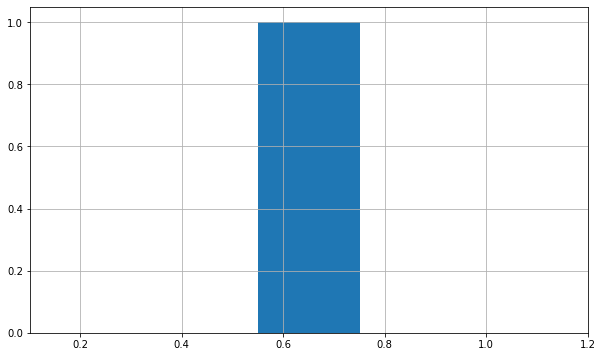

In [513]:
results[(results.tm_score_norm_ref_p1.astype(float) > tm_score_threshold) & (results.rmsd.astype(float) <= rmsd_threshold)].tm_score_norm_ref_p1.astype(float).hist(bins=5, figsize=(10,6));

# TM-Align Function

In [544]:
import io
import os
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from google.cloud import storage
from multiprocessing import Pool
import random

In [739]:
# generates protein combinations, runs tmalign on each, and saves results into a df

def process_report(p1, p2, pld):
    aligned_length, rmsd, tm_score_norm_ref_p1, p1_length, p2_length = 0,0,0,0,0
    result = []
    for line in pld:
        if 'Aligned length' in line:
            bits = line.split(',')
            aligned_length = int(''.join([n for n in bits[0] if n in '.0123456789']))
            rmsd = float(''.join([n for n in bits[1] if n in '.0123456789']))
        if 'normalized by length of Chain_1' in line:
            bits = line.split('=')
            tm_score_norm_ref_p1 = float(''.join([n for n in bits[1][:10] if n in '.0123456789']))
        if 'Length of Chain_1' in line:
            p1_length = int(''.join([n for n in line[18:] if n in '.0123456789']))
        if 'Length of Chain_2' in line:
            p2_length = int(''.join([n for n in line[18:] if n in '.0123456789']))
    result = [p1, p1_length, p2, p2_length, aligned_length, rmsd, tm_score_norm_ref_p1]
    return result


def tmalign(pairs_and_labels, chunk=0):
    '''
    Accepts an n x 3 (query protein, target protein and cluster label) or n x 2 array (query protein and target protein).
    Returns an n x 8 array with original inputs and TM-Align stats for each pair of proteins in the input array. Also writes
    results to pairs_tmalign_rmsd.parquet.
    
    NOTE: The parquet writing is broken at the moment due to multithreading, but the return results is 100% correct, so just
    write your results to file outside this function.
    '''
    result = []
    names = ['query_protein', 'query_protein_length', 'target_protein',
             'target_protein_length', 'aligned_length', 'rmsd', 'tmalign_score']
    for pair in pairs_and_labels:
        if pair[0] != pair[1]:
            cmd = f'/home/jupyter/pss/tmalign/TMalign /home/jupyter/pss/final_pdbs/{pair[0]}.pdb /home/jupyter/pss/final_pdbs/{pair[1]}.pdb'
            tmalign_report = os.popen(cmd).readlines()
            result.append(process_report(pair[0], pair[1], tmalign_report))
            if pairs_and_labels.shape[1] == 3:
                result[-1].append(pair[2])
    if pairs_and_labels.shape[1] == 3:
        names.append('cluster')
    #table = pa.Table.from_pandas(pd.DataFrame(result, columns=names))
    #pq.write_table(table, f'pairs_tmalign_rmsd_{str(chunk)}.parquet')
    return result

In [475]:
# test data for functions

combinations = np.array([['AF-Q8N1S5-F1-model_v1', 'AF-Q13433-F1-model_v1'], ['AF-Q8N1S5-F1-model_v1', 'AF-Q9ULF5-F1-model_v1']])
tmalign(combinations)
pd.read_parquet('pairs_tmalign_rmsd.parquet')

,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tmalign_score
0,AF-Q8N1S5-F1-model_v1,342,AF-Q13433-F1-model_v1,755,278,3.59,0.69422
1,AF-Q8N1S5-F1-model_v1,342,AF-Q9ULF5-F1-model_v1,831,270,3.58,0.66977


In [545]:
def download_file(path):
        data=[]
        os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "PSS GCS Storage Key.json"
        storage_client = storage.Client()
        blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(path)
        blob.download_to_filename(path.split('/')[-1])

        
download_file('samples/all_protein_combos_per_cluster.parquet')
pd.read_parquet('all_protein_combos_per_cluster.parquet').head()

,query_protein,target_protein,cluster
1,O96009,P00797,0
2,O96009,P07339,0
3,O96009,P0DJD7,0
4,O96009,P0DJD8,0
5,O96009,P0DJD9,0


In [743]:
combos = pd.read_parquet('all_protein_combos_per_cluster.parquet')
combos.query_protein = 'AF-' + combos.query_protein.astype(str) + '-F1-model_v1'
combos.target_protein = 'AF-' + combos.target_protein.astype(str) + '-F1-model_v1'
test_combos = combos[:1000][['query_protein', 'target_protein', 'cluster']].values

In [742]:
# SINGLE THREAD (SLOWER)

start = time.time()
answer = tmalign(test_combos)
print(f"took {int(time.time() - start)} seconds")
print(f'Sent {len(test_combos)} records and got back {len(answer)}.')
pd.read_parquet('pairs_tmalign_rmsd_0.parquet').sample(10)

took 38 seconds
Sent 250 records and got back 250.


,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tmalign_score,cluster
248,AF-A0A0A0MT70-F1-model_v1,17,AF-A0N4Z3-F1-model_v1,17,15,0.85,0.53660,1
4,AF-O96009-F1-model_v1,420,AF-P0DJD9-F1-model_v1,388,360,2.46,0.80155,0
245,AF-A0A0A0MT70-F1-model_v1,17,AF-A0A0J9YXM7-F1-model_v1,16,8,0.33,0.33505,1
239,AF-A0A0A0MT70-F1-model_v1,17,AF-A0A0B4J200-F1-model_v1,16,10,1.26,0.25688,1
65,AF-P20142-F1-model_v1,388,AF-P07339-F1-model_v1,412,374,2.82,0.89112,0
25,AF-P07339-F1-model_v1,412,AF-P56817-F1-model_v1,501,328,2.67,0.72858,0
17,AF-P00797-F1-model_v1,406,AF-Q9Y5Z0-F1-model_v1,518,326,2.91,0.72711,0
124,AF-A0A075B6V2-F1-model_v1,18,AF-A0A0B4J200-F1-model_v1,16,16,1.10,0.33639,1
60,AF-P14091-F1-model_v1,396,AF-P20142-F1-model_v1,388,371,2.06,0.88986,0
0,AF-O96009-F1-model_v1,420,AF-P00797-F1-model_v1,406,369,1.99,0.83341,0


In [ ]:
# OPTIMIZED OVER DEEPFOLD (FASTEST)

import time

names = ['query_protein', 'query_protein_length', 'target_protein',
         'target_protein_length', 'aligned_length', 'rmsd', 'tmalign_score', 'cluster']
size = len(test_combos)
h = []
num_threads = 7

start = time.time()

with Pool(num_threads) as p:
    h.append(p.map(tmalign, [test_combos[start::int(size / num_threads)+1] for start in range(int(size / num_threads)+1)]))
    
print(f"took {int(time.time() - start)} seconds")

res = []
for a in h:
    for b in a:
        for c in b:
            res.append(c)

res = pd.DataFrame(res, columns=names)        
print(f'Sent {len(test_combos)} records and got back {len(res)}.')
res.sample(10)

table = pa.Table.from_pandas(res)
pq.write_table(table, f'pairs_tmalign_rmsd.parquet')